<a href="https://colab.research.google.com/github/nisha-s10/Pattern-Recognition-Lab-AFI504/blob/main/Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STEP 1: Import Required Libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist

### STEP 2: Load and Preprocess Iris Dataset

In [47]:
iris = load_iris()
X = iris.data
y = iris.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### STEP 3: Implement LDA From Scratch
✔ Assumption:
* Gaussian distribution
* Same covariance matrix for all classes

In [48]:
class LDA:
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_features = X.shape[1]

        self.means = {}
        self.priors = {}

        # Compute means and priors
        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.priors[c] = X_c.shape[0] / X.shape[0]

        # Pooled covariance matrix
        cov = np.zeros((n_features, n_features))
        for c in self.classes:
            X_c = X[y == c]
            cov += np.cov(X_c, rowvar=False) * (X_c.shape[0] - 1)

        self.cov = cov / (X.shape[0] - len(self.classes))
        # Add regularization
        epsilon = 1e-4
        self.cov += epsilon * np.eye(n_features)

        self.inv_cov = np.linalg.inv(self.cov)


    def predict(self, X):
        predictions = []

        for x in X:
            scores = []
            for c in self.classes:
                mean = self.means[c]
                prior = np.log(self.priors[c])

                score = (x @ self.inv_cov @ mean
                        - 0.5 * mean @ self.inv_cov @ mean
                        + prior)

                scores.append(score)

            predictions.append(self.classes[np.argmax(scores)])

        return np.array(predictions)

### STEP 4: Implement QDA From Scratch
✔ Assumption:
* Gaussian distribution
* Different covariance for each class

In [49]:
class QDA:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {}
        self.covs = {}
        self.inv_cov = {}
        self.det_cov = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.priors[c] = X_c.shape[0] / X.shape[0]

            cov = np.cov(X_c, rowvar=False)

            # Regularization (VERY IMPORTANT)
            epsilon = 1e-2
            cov += epsilon * np.eye(cov.shape[0])

            self.covs[c] = cov
            self.inv_cov[c] = np.linalg.inv(cov)
            self.det_cov[c] = np.linalg.det(cov)

    def predict(self, X):
        predictions = []

        for x in X:
            scores = []
            for c in self.classes:
                mean = self.means[c]
                inv_cov = self.inv_cov[c]
                det_cov = self.det_cov[c]
                prior = np.log(self.priors[c])

                term1 = -0.5 * np.log(det_cov)
                term2 = -0.5 * (x - mean).T @ inv_cov @ (x - mean)

                scores.append(term1 + term2 + prior)

            predictions.append(self.classes[np.argmax(scores)])

        return np.array(predictions)

### STEP 5: Train and Test on Iris Dataset

In [50]:
lda = LDA()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("Iris LDA Accuracy:", np.mean(y_pred_lda == y_test))

qda = QDA()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)
print("Iris QDA Accuracy:", np.mean(y_pred_qda == y_test))

Iris LDA Accuracy: 1.0
Iris QDA Accuracy: 1.0


### Iris Visualization (Decision Boundary)

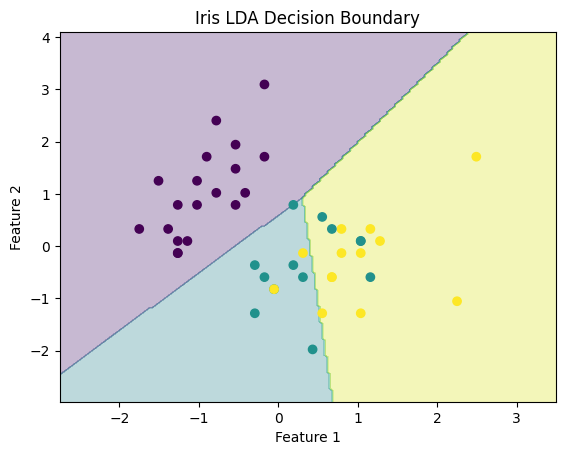

In [51]:
# Use only first 2 features for visualization
X_vis = iris.data[:, :2]
y_vis = iris.target

scaler = StandardScaler()
X_vis = scaler.fit_transform(X_vis)

X_train, X_test, y_train, y_test = train_test_split(
    X_vis, y_vis, test_size=0.3, random_state=42
)

lda = LDA()
lda.fit(X_train, y_train)

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_decision_boundary(lda, X_test, y_test, "Iris LDA Decision Boundary")

### STEP 6: Load and Preprocess MNIST Dataset

In [52]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten images
X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

# Reduce size for computation
X_train = X_train[:5000]
y_train = y_train[:5000]

X_test = X_test[:1000]
y_test = y_test[:1000]

### STEP 7: Train and Test on MNIST

In [53]:
lda = LDA()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("MNIST LDA Accuracy:", np.mean(y_pred_lda == y_test))

qda = QDA()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)
print("MNIST QDA Accuracy:", np.mean(y_pred_qda == y_test))

from sklearn.decomposition import PCA

pca = PCA(n_components=50)   # try 50 first
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

qda = QDA()
qda.fit(X_train_pca, y_train)
y_pred_qda = qda.predict(X_test_pca)

print("MNIST QDA Accuracy after PCA:", np.mean(y_pred_qda == y_test))

MNIST LDA Accuracy: 0.824


/tmp/ipython-input-1645725600.py:36: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5 * np.log(det_cov)


MNIST QDA Accuracy: 0.085
MNIST QDA Accuracy after PCA: 0.95


### MNIST Visualization Using PCA

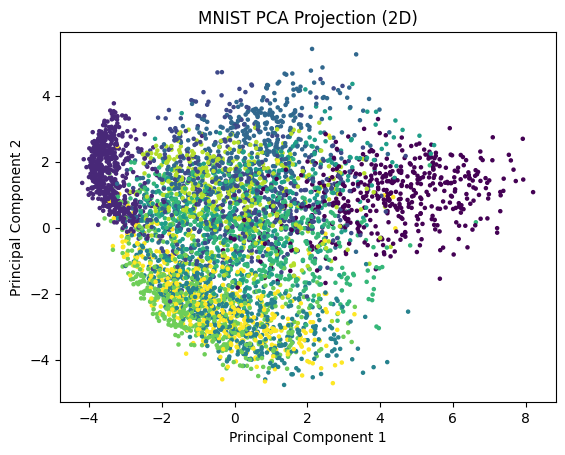

In [54]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)

X_train_2d = pca_2d.fit_transform(X_train)
X_test_2d = pca_2d.transform(X_test)


plt.figure()
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, s=5)
plt.title("MNIST PCA Projection (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### PCA Explained Variance Plot

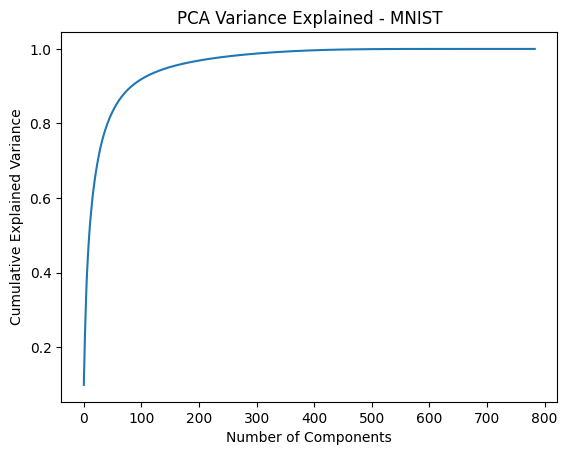

In [55]:
pca_full = PCA()
pca_full.fit(X_train)

plt.figure()
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Variance Explained - MNIST")
plt.show()

###Confusion Matrix Visualization

In [56]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    plt.show()

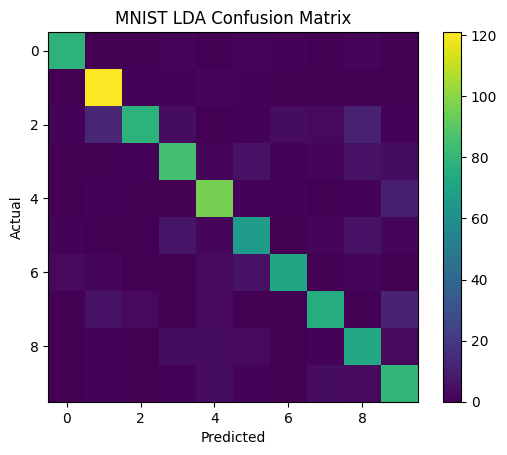

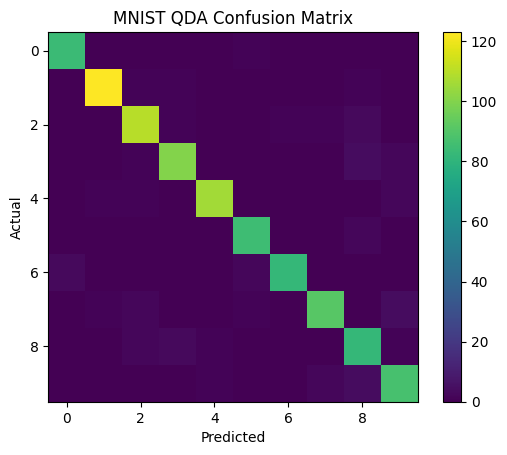

In [57]:
# LDA Confusion Matrix
plot_confusion(y_test, y_pred_lda, "MNIST LDA Confusion Matrix")

# QDA Confusion Matrix
plot_confusion(y_test, y_pred_qda, "MNIST QDA Confusion Matrix")

## Step 8: Final Comparison
\begin{array}{|l|c|c|}
\hline
\textbf{Dataset} & \textbf{Linear\ Discriminant\ Analysis} & \textbf{Quadratic\ Discriminant\ Analysis} \\
\hline
\text{Iris Dataset} & \text{Very High Accuracy} & \text{Very High Accuracy} \\
\hline
\text{MNIST Dataset} & \text{Good Accuracy} & \text{Moderate Accuracy} \\
\hline
\end{array}
